## Preparation

### import relevent package

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="`imread` is deprecated!")
warnings.filterwarnings("ignore", message="`np.float` is a deprecated alias!")
warnings.filterwarnings("ignore", message="`imresize` is deprecated!")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import tensorflow as tf
import tensorflow.contrib.slim as slim
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.set_random_seed(289)
import time
from model import cyclegan
from glob import glob
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import copy
if not os.path.exists('./checkpoint'):
    os.makedirs('./checkpoint')   


### Environment required

In [2]:
print(scipy.__version__)
print(tf.__version__)

1.1.0
1.14.0


### Prepare for the basic function

In [3]:
def batch_norm(x, name="batch_norm"):
    return tf.contrib.layers.batch_norm(x, decay=0.9, updates_collections=None, epsilon=1e-5, scale=True, scope=name)

def instance_norm(input, name="instance_norm"):
    with tf.variable_scope(name):
        depth = input.get_shape()[3]
        scale = tf.get_variable("scale", [depth], initializer=tf.random_normal_initializer(1.0, 0.02, dtype=tf.float32))
        offset = tf.get_variable("offset", [depth], initializer=tf.constant_initializer(0.0))
        mean, variance = tf.nn.moments(input, axes=[1,2], keep_dims=True)
        epsilon = 1e-5
        inv = tf.rsqrt(variance + epsilon)
        normalized = (input-mean)*inv
        return scale*normalized + offset

def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name="conv2d"):
    with tf.variable_scope(name):
        return slim.conv2d(input_, output_dim, ks, s, padding=padding, activation_fn=None,
                            weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                            biases_initializer=None)

def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        return slim.conv2d_transpose(input_, output_dim, ks, s, padding='SAME', activation_fn=None,
                                    weights_initializer=tf.truncated_normal_initializer(stddev=stddev),
                                    biases_initializer=None)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [input_.get_shape()[-1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias


### Prepare for the loading and processing function for data

In [4]:
def load_train_data(image_path, load_size=286, fine_size=256, is_testing=False):
    img_A = imread(image_path[0])
    img_B = imread(image_path[1])
    if not is_testing:
        img_A = scipy.misc.imresize(img_A, [load_size, load_size])
        img_B = scipy.misc.imresize(img_B, [load_size, load_size])
        h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
        w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
        img_A = img_A[h1:h1+fine_size, w1:w1+fine_size]
        img_B = img_B[h1:h1+fine_size, w1:w1+fine_size]

        if np.random.random() > 0.5:
            img_A = np.fliplr(img_A)
            img_B = np.fliplr(img_B)
    else:
        img_A = scipy.misc.imresize(img_A, [fine_size, fine_size])
        img_B = scipy.misc.imresize(img_B, [fine_size, fine_size])

    img_A = img_A/127.5 - 1.
    img_B = img_B/127.5 - 1.

    img_AB = np.concatenate((img_A, img_B), axis=2)
    # img_AB shape: (fine_size, fine_size, input_c_dim + output_c_dim)
    return img_AB

def load_test_data(image_path, fine_size=256):
    img = imread(image_path)
    img = scipy.misc.imresize(img, [fine_size, fine_size])
    img = img/127.5 - 1
    return img

class ImagePool(object):
    def __init__(self, maxsize=50):
        self.maxsize = maxsize
        self.num_img = 0
        self.images = []

    def __call__(self, image):
        if self.maxsize <= 0:
            return image
        if self.num_img < self.maxsize:
            self.images.append(image)
            self.num_img += 1
            return image
        if np.random.rand() > 0.5:
            idx = int(np.random.rand()*self.maxsize)
            tmp1 = copy.copy(self.images[idx])[0]
            self.images[idx][0] = image[0]
            idx = int(np.random.rand()*self.maxsize)
            tmp2 = copy.copy(self.images[idx])[1]
            self.images[idx][1] = image[1]
            return [tmp1, tmp2]
        else:
            return image
# Processing and saving the  image function
def get_image(image_path, image_size, is_crop=True, resize_w=64, is_grayscale = False):
    return transform(imread(image_path, is_grayscale), image_size, is_crop, resize_w)

def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imread(path, is_grayscale = False):
    if (is_grayscale):
        return scipy.misc.imread(path, flatten = True).astype(np.float)
    else:
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

def merge_images(images, size):
    return inverse_transform(images)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
        h, w = x.shape[:2]
        j = int(round((h - crop_h)/2.))
        i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(
          x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, npx=64, is_crop=True, resize_w=64):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx, resize_w=resize_w)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.


## Load in the data and visualize

C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipy

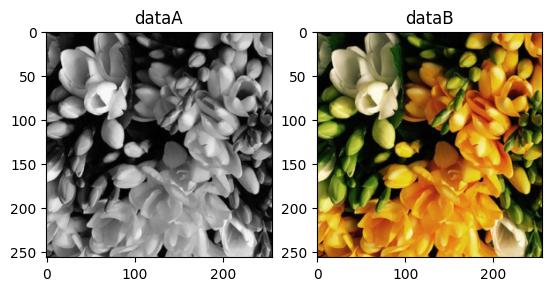

In [5]:
dataA = glob('./datasets/{}/*.*'.format('flower_images/trainA'))
dataB = glob('./datasets/{}/*.*'.format('flower_images/trainB'))

batch_files = list(zip(dataA[3:4], dataB[3:4]))
batch_images = [load_train_data(batch_file, 286, 256) for batch_file in batch_files]
batch_images = np.array(batch_images).astype(np.float32)
plt.subplot(121)
plt.title('dataA')
plt.imshow(batch_images[0][..., :3] * 0.5 + 0.5)

plt.subplot(122)
plt.title('dataB')
plt.imshow(batch_images[0][..., 3:] * 0.5 + 0.5)

## Generator

### resnet

In [6]:
def generator_resnet(image, options, reuse=False, name="generator"):

    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        def residule_block(x, dim, ks=3, s=1, name='res'):
            p = int((ks - 1) / 2)
            y = tf.pad(x, [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c1'), name+'_bn1')
            y = tf.pad(tf.nn.relu(y), [[0, 0], [p, p], [p, p], [0, 0]], "REFLECT")
            y = instance_norm(conv2d(y, dim, ks, s, padding='VALID', name=name+'_c2'), name+'_bn2')
            return y + x

        # Justin Johnson's model from https://github.com/jcjohnson/fast-neural-style/
        # The network with 9 blocks consists of: c7s1-32, d64, d128, R128, R128, R128,
        # R128, R128, R128, R128, R128, R128, u64, u32, c7s1-3
        c0 = tf.pad(image, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        c1 = tf.nn.relu(instance_norm(conv2d(c0, options.gf_dim, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
        c2 = tf.nn.relu(instance_norm(conv2d(c1, options.gf_dim*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
        c3 = tf.nn.relu(instance_norm(conv2d(c2, options.gf_dim*4, 3, 2, name='g_e3_c'), 'g_e3_bn'))
        # define G network with 9 resnet blocks
        r1 = residule_block(c3, options.gf_dim*4, name='g_r1')
        r2 = residule_block(r1, options.gf_dim*4, name='g_r2')
        r3 = residule_block(r2, options.gf_dim*4, name='g_r3')
        r4 = residule_block(r3, options.gf_dim*4, name='g_r4')
        r5 = residule_block(r4, options.gf_dim*4, name='g_r5')
        r6 = residule_block(r5, options.gf_dim*4, name='g_r6')
        r7 = residule_block(r6, options.gf_dim*4, name='g_r7')
        r8 = residule_block(r7, options.gf_dim*4, name='g_r8')
        r9 = residule_block(r8, options.gf_dim*4, name='g_r9')

        d1 = deconv2d(r9, options.gf_dim*2, 3, 2, name='g_d1_dc')
        d1 = tf.nn.relu(instance_norm(d1, 'g_d1_bn'))
        d2 = deconv2d(d1, options.gf_dim, 3, 2, name='g_d2_dc')
        d2 = tf.nn.relu(instance_norm(d2, 'g_d2_bn'))
        d2 = tf.pad(d2, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        pred = tf.nn.tanh(conv2d(d2, options.output_c_dim, 7, 1, padding='VALID', name='g_pred_c'))

        return pred

### unet

In [7]:
def generator_unet(image, options, reuse=False, name="generator"):

    dropout_rate = 0.5 if options.is_training else 1.0
    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        # image is (256 x 256 x input_c_dim)
        e1 = instance_norm(conv2d(image, options.gf_dim, name='g_e1_conv'))
        # e1 is (128 x 128 x self.gf_dim)
        e2 = instance_norm(conv2d(lrelu(e1), options.gf_dim*2, name='g_e2_conv'), 'g_bn_e2')
        # e2 is (64 x 64 x self.gf_dim*2)
        e3 = instance_norm(conv2d(lrelu(e2), options.gf_dim*4, name='g_e3_conv'), 'g_bn_e3')
        # e3 is (32 x 32 x self.gf_dim*4)
        e4 = instance_norm(conv2d(lrelu(e3), options.gf_dim*8, name='g_e4_conv'), 'g_bn_e4')
        # e4 is (16 x 16 x self.gf_dim*8)
        e5 = instance_norm(conv2d(lrelu(e4), options.gf_dim*8, name='g_e5_conv'), 'g_bn_e5')
        # e5 is (8 x 8 x self.gf_dim*8)
        e6 = instance_norm(conv2d(lrelu(e5), options.gf_dim*8, name='g_e6_conv'), 'g_bn_e6')
        # e6 is (4 x 4 x self.gf_dim*8)
        e7 = instance_norm(conv2d(lrelu(e6), options.gf_dim*8, name='g_e7_conv'), 'g_bn_e7')
        # e7 is (2 x 2 x self.gf_dim*8)
        e8 = instance_norm(conv2d(lrelu(e7), options.gf_dim*8, name='g_e8_conv'), 'g_bn_e8')
        # e8 is (1 x 1 x self.gf_dim*8)

        d1 = deconv2d(tf.nn.relu(e8), options.gf_dim*8, name='g_d1')
        d1 = tf.nn.dropout(d1, dropout_rate)
        d1 = tf.concat([instance_norm(d1, 'g_bn_d1'), e7], 3)
        # d1 is (2 x 2 x self.gf_dim*8*2)

        d2 = deconv2d(tf.nn.relu(d1), options.gf_dim*8, name='g_d2')
        d2 = tf.nn.dropout(d2, dropout_rate)
        d2 = tf.concat([instance_norm(d2, 'g_bn_d2'), e6], 3)
        # d2 is (4 x 4 x self.gf_dim*8*2)

        d3 = deconv2d(tf.nn.relu(d2), options.gf_dim*8, name='g_d3')
        d3 = tf.nn.dropout(d3, dropout_rate)
        d3 = tf.concat([instance_norm(d3, 'g_bn_d3'), e5], 3)
        # d3 is (8 x 8 x self.gf_dim*8*2)

        d4 = deconv2d(tf.nn.relu(d3), options.gf_dim*8, name='g_d4')
        d4 = tf.concat([instance_norm(d4, 'g_bn_d4'), e4], 3)
        # d4 is (16 x 16 x self.gf_dim*8*2)

        d5 = deconv2d(tf.nn.relu(d4), options.gf_dim*4, name='g_d5')
        d5 = tf.concat([instance_norm(d5, 'g_bn_d5'), e3], 3)
        # d5 is (32 x 32 x self.gf_dim*4*2)

        d6 = deconv2d(tf.nn.relu(d5), options.gf_dim*2, name='g_d6')
        d6 = tf.concat([instance_norm(d6, 'g_bn_d6'), e2], 3)
        # d6 is (64 x 64 x self.gf_dim*2*2)

        d7 = deconv2d(tf.nn.relu(d6), options.gf_dim, name='g_d7')
        d7 = tf.concat([instance_norm(d7, 'g_bn_d7'), e1], 3)
        # d7 is (128 x 128 x self.gf_dim*1*2)

        d8 = deconv2d(tf.nn.relu(d7), options.output_c_dim, name='g_d8')
        # d8 is (256 x 256 x output_c_dim)

        return tf.nn.tanh(d8)

## Discriminator

In [8]:
def discriminator(image, options, reuse=False, name="discriminator"):

    with tf.variable_scope(name):
        # image is 256 x 256 x input_c_dim
        if reuse:
            tf.get_variable_scope().reuse_variables()
        else:
            assert tf.get_variable_scope().reuse is False

        h0 = lrelu(conv2d(image, options.df_dim, name='d_h0_conv'))
        # h0 is (128 x 128 x self.df_dim)
        h1 = lrelu(instance_norm(conv2d(h0, options.df_dim*2, name='d_h1_conv'), 'd_bn1'))
        # h1 is (64 x 64 x self.df_dim*2)
        h2 = lrelu(instance_norm(conv2d(h1, options.df_dim*4, name='d_h2_conv'), 'd_bn2'))
        # h2 is (32x 32 x self.df_dim*4)
        h3 = lrelu(instance_norm(conv2d(h2, options.df_dim*8, s=1, name='d_h3_conv'), 'd_bn3'))
        # h3 is (32 x 32 x self.df_dim*8)
        h4 = conv2d(h3, 1, s=1, name='d_h3_pred')
        # h4 is (32 x 32 x 1)
        return h4

## Loss function

In [9]:
def abs_criterion(in_, target):
    return tf.reduce_mean(tf.abs(in_ - target))


def mae_criterion(in_, target):
    return tf.reduce_mean((in_-target)**2)


def sce_criterion(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

## Building CycleGAN model

In [10]:
def load_weights(saver, sess, model_dir):
        ckpt = tf.train.get_checkpoint_state(model_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            saver.restore(sess, os.path.join(model_dir, ckpt_name))
            return True
        else:
            return False               
                    
        
def Save(saver, sess, checkpoint_dir, step):
        dir = os.path.join(checkpoint_dir, "model")
        saver.save(sess, dir)
class cyclegan(object):
    def __init__(self, sess):
        self.sess = sess
        self.batch_size = 1
        self.image_size = 256
        self.load_size = 286        # scale images to this size
        self.fine_size = 256        # then crop to this size
        self.train_size = 1e8
        self.input_c_dim = 3        # of input image channels            
        self.output_c_dim = 3       # of output image channels
        self.L1_lambda = 10.0
        self.dataset_dir = 'flower_images'
        self.ndf = 64               # number of generator filters in first conv layer
        self.ngf = 64               # number of discriminator filters in first conv layer
        
        self.phase = 'train'

        self.discriminator = discriminator
        self.generator = generator_resnet
        self.criterionGAN = mae_criterion
        
        OPTIONS = namedtuple('OPTIONS', 'batch_size image_size \
                              gf_dim df_dim output_c_dim is_training')
        self.options = OPTIONS._make((self.batch_size, self.fine_size,
                                      self.ngf, self.ndf, self.output_c_dim, self.phase == 'train'))
                                                                           

        self._build_model()
        self.saver = tf.train.Saver()
        self.pool = ImagePool(50)

    def _build_model(self):
        self.real_data = tf.placeholder(tf.float32,
                                        [None, self.image_size, self.image_size,
                                         self.input_c_dim + self.output_c_dim],
                                        name='real_A_and_B_images')

        self.real_A = self.real_data[:, :, :, :self.input_c_dim]
        self.real_B = self.real_data[:, :, :, self.input_c_dim:self.input_c_dim + self.output_c_dim]

        self.fake_B = self.generator(self.real_A, self.options, False, name="generatorA2B")
        self.fake_A_ = self.generator(self.fake_B, self.options, False, name="generatorB2A")
        self.fake_A = self.generator(self.real_B, self.options, True, name="generatorB2A")
        self.fake_B_ = self.generator(self.fake_A, self.options, True, name="generatorA2B")

        self.DB_fake = self.discriminator(self.fake_B, self.options, reuse=False, name="discriminatorB")
        self.DA_fake = self.discriminator(self.fake_A, self.options, reuse=False, name="discriminatorA")
        
        self.g_loss_a2b = self.criterionGAN(self.DB_fake, tf.ones_like(self.DB_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        
        self.g_loss_b2a = self.criterionGAN(self.DA_fake, tf.ones_like(self.DA_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)
        
        self.g_loss = self.criterionGAN(self.DA_fake, tf.ones_like(self.DA_fake)) \
            + self.criterionGAN(self.DB_fake, tf.ones_like(self.DB_fake)) \
            + self.L1_lambda * abs_criterion(self.real_A, self.fake_A_) \
            + self.L1_lambda * abs_criterion(self.real_B, self.fake_B_)

        
        self.fake_A_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.input_c_dim], name='fake_A_sample')
        self.fake_B_sample = tf.placeholder(tf.float32,
                                            [None, self.image_size, self.image_size,
                                             self.output_c_dim], name='fake_B_sample')
        
        self.DB_real = self.discriminator(self.real_B, self.options, reuse=True, name="discriminatorB")
        self.DA_real = self.discriminator(self.real_A, self.options, reuse=True, name="discriminatorA")
        self.DB_fake_sample = self.discriminator(self.fake_B_sample, self.options, reuse=True, name="discriminatorB")
        self.DA_fake_sample = self.discriminator(self.fake_A_sample, self.options, reuse=True, name="discriminatorA")

        
        self.db_loss_real = self.criterionGAN(self.DB_real, tf.ones_like(self.DB_real))
        self.db_loss_fake = self.criterionGAN(self.DB_fake_sample, tf.zeros_like(self.DB_fake_sample))
        self.db_loss = (self.db_loss_real + self.db_loss_fake) / 2
        
        self.da_loss_real = self.criterionGAN(self.DA_real, tf.ones_like(self.DA_real))
        self.da_loss_fake = self.criterionGAN(self.DA_fake_sample, tf.zeros_like(self.DA_fake_sample))
        self.da_loss = (self.da_loss_real + self.da_loss_fake) / 2
        
        self.d_loss = self.da_loss + self.db_loss

        self.g_loss_a2b_sum = tf.summary.scalar("g_loss_a2b", self.g_loss_a2b)
        self.g_loss_b2a_sum = tf.summary.scalar("g_loss_b2a", self.g_loss_b2a)
        
        self.g_loss_sum = tf.summary.scalar("g_loss", self.g_loss)
        self.g_sum = tf.summary.merge([self.g_loss_a2b_sum, self.g_loss_b2a_sum, self.g_loss_sum])
        
        
        self.db_loss_sum = tf.summary.scalar("db_loss", self.db_loss)
        self.da_loss_sum = tf.summary.scalar("da_loss", self.da_loss)
        self.d_loss_sum = tf.summary.scalar("d_loss", self.d_loss)
        
        self.db_loss_real_sum = tf.summary.scalar("db_loss_real", self.db_loss_real)
        self.db_loss_fake_sum = tf.summary.scalar("db_loss_fake", self.db_loss_fake)
        self.da_loss_real_sum = tf.summary.scalar("da_loss_real", self.da_loss_real)
        self.da_loss_fake_sum = tf.summary.scalar("da_loss_fake", self.da_loss_fake)
        self.d_sum = tf.summary.merge([self.da_loss_sum, self.da_loss_real_sum, self.da_loss_fake_sum,
                                       self.db_loss_sum, self.db_loss_real_sum, self.db_loss_fake_sum,
                                       self.d_loss_sum])

        self.test_A = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.input_c_dim], name='test_A')
        self.test_B = tf.placeholder(tf.float32,
                                     [None, self.image_size, self.image_size,
                                      self.output_c_dim], name='test_B')
        self.testB = self.generator(self.test_A, self.options, True, name="generatorA2B")
        self.testA = self.generator(self.test_B, self.options, True, name="generatorB2A")
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'discriminator' in var.name]
        self.g_vars = [var for var in t_vars if 'generator' in var.name]
        for var in t_vars: print(var.name)

    def train(self):
        """Train cyclegan"""
        
        self.lr = tf.placeholder(tf.float32, None, name='learning_rate')
        self.d_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5) \
            .minimize(self.d_loss, var_list=self.d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5) \
            .minimize(self.g_loss, var_list=self.g_vars)
            
        sum1 = tf.summary.image("realA", self.real_A, max_outputs=1)    
        sum2 = tf.summary.image("fakeB", self.fake_B, max_outputs=1)
        sum3 = tf.summary.image("fakeA_", self.fake_A_, max_outputs=1)
        sum4 = tf.summary.image("realB", self.real_B, max_outputs=1)    
        sum5 = tf.summary.image("fakeA", self.fake_A, max_outputs=1)
        sum6 = tf.summary.image("fakeB_", self.fake_B_, max_outputs=1)
        self.image = tf.summary.merge([sum1, sum2, sum3, sum4, sum5, sum6])
        
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        saver = tf.train.Saver()
        load_weights(self.saver, self.sess, './checkpoint')
        self.writer = tf.summary.FileWriter("./logs", self.sess.graph)

        counter = 1
        start_time = time.time()
        

        lr = 0.0001
        self.epochs = 200
        for epoch in range(self.epochs):
            dataA = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/trainA'))
            dataB = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/trainB'))
            np.random.shuffle(dataA)
            np.random.shuffle(dataB)
            batch_idxs = min(min(len(dataA), len(dataB)), self.train_size) // self.batch_size

            
            

            for idx in range(0, batch_idxs):
                batch_files = list(zip(dataA[idx * self.batch_size:(idx + 1) * self.batch_size],
                                       dataB[idx * self.batch_size:(idx + 1) * self.batch_size]))
                batch_images = [load_train_data(batch_file, self.load_size, self.fine_size) for batch_file in batch_files]
                batch_images = np.array(batch_images).astype(np.float32)

                
                
                # Update G network and record fake outputs
                fake_A, fake_B, _, summary_str, summary_str2 = self.sess.run(
                    [self.fake_A, self.fake_B, self.g_optim, self.g_sum, self.image],
                    feed_dict={self.real_data: batch_images, self.lr: lr})
                self.writer.add_summary(summary_str, counter)
                self.writer.add_summary(summary_str2, counter)
                [fake_A, fake_B] = self.pool([fake_A, fake_B])

                # Update D network
                _, summary_str = self.sess.run(
                    [self.d_optim, self.d_sum],
                    feed_dict={self.real_data: batch_images,
                               self.fake_A_sample: fake_A,
                               self.fake_B_sample: fake_B,
                               self.lr: lr})
                self.writer.add_summary(summary_str, counter)

                counter += 1
                print(("Epoch: [%2d] [%4d/%4d] time: %4.4f" % (
                    epoch, idx, batch_idxs, time.time() - start_time)))
                
                if idx % 1000 == 0:    
                    Save(self.saver, self.sess, './checkpoint/', epoch)
    

    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoint...")

        model_dir = "%s_%s" % (self.dataset_dir, self.image_size)
        checkpoint_dir = os.path.join(checkpoint_dir) #, model_dir
        print(checkpoint_dir)
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        print(ckpt)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            return True
        else:
            return True

    def sample_model(self, sample_dir, epoch, idx):
        dataA = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testA'))
        dataB = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testB'))
        np.random.shuffle(dataA)
        np.random.shuffle(dataB)
        batch_files = list(zip(dataA[:self.batch_size], dataB[:self.batch_size]))
        sample_images = [load_train_data(batch_file, is_testing=True) for batch_file in batch_files]
        sample_images = np.array(sample_images).astype(np.float32)

        fake_A, fake_B = self.sess.run(
            [self.fake_A, self.fake_B],
            feed_dict={self.real_data: sample_images}
        )
        save_images(fake_A, [self.batch_size, 1],
                    './{}/A_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, idx))
        save_images(fake_B, [self.batch_size, 1],
                    './{}/B_{:02d}_{:04d}.jpg'.format(sample_dir, epoch, idx))

    def test(self, which_direction='AtoB', checkpoint_dir='./checkpoint', test_dir='./test'):
        """Test cyclegan"""
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        if which_direction == 'AtoB':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testA'))
            #print self.dataset_dir
        elif which_direction == 'BtoA':
            sample_files = glob('./datasets/{}/*.*'.format(self.dataset_dir + '/testB'))
        else:
            raise Exception('--which_direction must be AtoB or BtoA')
        #print args.checkpoint_dir
        if self.load(checkpoint_dir):
            print(" [*] Load SUCCESS")
        else:
            print(" [!] Load failed...")

        # write html for visual comparison
        index_path = os.path.join(test_dir, '{0}_index.html'.format(which_direction))
        index = open(index_path, "w")
        index.write("<html><body><table><tr>")
        index.write("<th>name</th><th>input</th><th>output</th></tr>")

        out_var, in_var = (self.testB, self.test_A) if which_direction == 'AtoB' else (
            self.testA, self.test_B)
        print(sample_files)
        for sample_file in sample_files:
            print('Processing image: ' + sample_file)
            sample_image = [load_test_data(sample_file, self.image_size)]
            sample_image = np.array(sample_image).astype(np.float32)
            image_path = os.path.join(test_dir,
                                      '{0}_{1}'.format(which_direction, os.path.basename(sample_file)))
            fake_img = self.sess.run(out_var, feed_dict={in_var: sample_image})
            save_images(fake_img, [1, 1], image_path)
            index.write("<td>%s</td>" % os.path.basename(image_path))
            index.write("<td><img src='%s'></td>" % (sample_file if os.path.isabs(sample_file) else (
                '..' + os.path.sep + sample_file)))
            index.write("<td><img src='%s'></td>" % (image_path if os.path.isabs(image_path) else (
                '..' + os.path.sep + image_path)))
            index.write("</tr>")
        index.close()


## Train the model

In [11]:
tfconfig = tf.ConfigProto(allow_soft_placement=True)
tfconfig.gpu_options.allow_growth = True
with tf.Session(config=tfconfig) as sess:
    model = cyclegan(sess)
    model.train()

generatorA2B/g_e1_c/Conv/weights:0
generatorA2B/g_e1_bn/scale:0
generatorA2B/g_e1_bn/offset:0
generatorA2B/g_e2_c/Conv/weights:0
generatorA2B/g_e2_bn/scale:0
generatorA2B/g_e2_bn/offset:0
generatorA2B/g_e3_c/Conv/weights:0
generatorA2B/g_e3_bn/scale:0
generatorA2B/g_e3_bn/offset:0
generatorA2B/g_r1_c1/Conv/weights:0
generatorA2B/g_r1_bn1/scale:0
generatorA2B/g_r1_bn1/offset:0
generatorA2B/g_r1_c2/Conv/weights:0
generatorA2B/g_r1_bn2/scale:0
generatorA2B/g_r1_bn2/offset:0
generatorA2B/g_r2_c1/Conv/weights:0
generatorA2B/g_r2_bn1/scale:0
generatorA2B/g_r2_bn1/offset:0
generatorA2B/g_r2_c2/Conv/weights:0
generatorA2B/g_r2_bn2/scale:0
generatorA2B/g_r2_bn2/offset:0
generatorA2B/g_r3_c1/Conv/weights:0
generatorA2B/g_r3_bn1/scale:0
generatorA2B/g_r3_bn1/offset:0
generatorA2B/g_r3_c2/Conv/weights:0
generatorA2B/g_r3_bn2/scale:0
generatorA2B/g_r3_bn2/offset:0
generatorA2B/g_r4_c1/Conv/weights:0
generatorA2B/g_r4_bn1/scale:0
generatorA2B/g_r4_bn1/offset:0
generatorA2B/g_r4_c2/Conv/weights:0
gen

C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  """
C:\Users\dinol\anaconda3\envs\py37\lib\site-packages\ipy

Epoch: [ 0] [   0/1812] time: 12.4938
Epoch: [ 0] [   1/1812] time: 22.2398
Epoch: [ 0] [   2/1812] time: 31.8300
Epoch: [ 0] [   3/1812] time: 41.3950
Epoch: [ 0] [   4/1812] time: 50.9023
Epoch: [ 0] [   5/1812] time: 60.4515
Epoch: [ 0] [   6/1812] time: 69.6038
Epoch: [ 0] [   7/1812] time: 78.8897
Epoch: [ 0] [   8/1812] time: 88.2139
Epoch: [ 0] [   9/1812] time: 97.2335
Epoch: [ 0] [  10/1812] time: 106.3904
Epoch: [ 0] [  11/1812] time: 115.5986
Epoch: [ 0] [  12/1812] time: 125.1127
Epoch: [ 0] [  13/1812] time: 134.5095
Epoch: [ 0] [  14/1812] time: 143.7190
Epoch: [ 0] [  15/1812] time: 152.8686
Epoch: [ 0] [  16/1812] time: 162.0860
Epoch: [ 0] [  17/1812] time: 171.3636
Epoch: [ 0] [  18/1812] time: 180.5981
Epoch: [ 0] [  19/1812] time: 189.8276
Epoch: [ 0] [  20/1812] time: 198.9034
Epoch: [ 0] [  21/1812] time: 207.9985
Epoch: [ 0] [  22/1812] time: 217.0282
Epoch: [ 0] [  23/1812] time: 226.0957
Epoch: [ 0] [  24/1812] time: 235.2345
Epoch: [ 0] [  25/1812] time: 244.4

KeyboardInterrupt: 

## Test the model and visualize

In [2]:
checkpoint_dir = "checkpoint/flower_images_256"
dataset_dir="flower_images"
with tf.Session(config=tfconfig) as sess:
    model = cyclegan(sess)
    model.test(checkpoint_dir=checkpoint_dir)






Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


generatorA2B/g_e1_c/Conv/weights:0
generatorA2B/g_e1_bn/scale:0
generatorA2B/g_e1_bn/offset:0
generatorA2B/g_e2_c/Conv/weights:0
generatorA2B/g_e2_bn/scale:0
generatorA2B/g_e2_bn/offset:0
generatorA2B/g_e3_c/Conv/weights:0
generatorA2B/g_e3_bn/scale:0
generatorA2B/g_e3_bn/offset:0
generatorA2B/g_r1_c1/Conv/weights:0
generatorA2B/g_r1_bn1/scale:0
generatorA2B/g_r1_bn1/offset:0
generatorA2B/g_r1_c2/Conv/weights:0
generatorA2B/g_r1_bn2/scale:0
generatorA2B/g_r1_bn2/offset:0
generatorA2B/g_r2_c1/Conv/weights:0
generatorA2B/g_r2_bn1/scale:0
generatorA2B/g_r2_bn1/offset:0
generatorA2B/g_r2_c2/Conv/weights:0
generatorA2B/g_r2_bn2/scale:0
generatorA2B/g_r2_bn2/offset:0
generatorA2B/g_r3_c1/Conv/weights:0
generatorA2B/g_r3_bn1/scale:0
generatorA2B/g_r3_bn1/offset:0
generatorA2B/g_r3_c2/Conv/weights:0
generatorA2B/g_r3_bn2/scale:0
generatorA2B/g_r3_bn2/offset:0
generatorA2B/g_r4_c1/Conv/weights:0
generatorA2B/g_r4_bn1/scale:0
generatorA2B/g_r4_bn1/offset:0
generatorA2B/g_r4_c2/Conv/weights:0
gen

 [*] Reading checkpoint...
checkpoint/flower_images_256
model_checkpoint_path: "checkpoint/flower_images_256\\cyclegan.model-90002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-86002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-87002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-88002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-89002"
all_model_checkpoint_paths: "checkpoint/flower_images_256\\cyclegan.model-90002"

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/flower_images_256\cyclegan.model-90002
 [*] Load SUCCESS
['./datasets/flower_images/testA\\01.png', './datasets/flower_images/testA\\02.png', './datasets/flower_images/testA\\03.png', './datasets/flower_images/testA\\04.png', './datasets/flower_images/testA\\05.png', './datasets/flower_images/testA\\06.png', './datasets/

In [29]:
inputs = glob("datasets/{}/testA/*.png*".format(dataset_dir))
outputs = glob("test/*.png*")

batch_files = list(zip(inputs[0:9], outputs[0:9]))
batch_images = [load_train_data(batch_file, 286, 256) for batch_file in batch_files]
batch_images = np.array(batch_images).astype(np.float32)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, imgs in enumerate(batch_images):
    ax[i, 0].imshow(imgs[..., :3] * 0.5 + 0.5)
    ax[i, 1].imshow(imgs[..., 3:] * 0.5 + 0.5)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Output Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

NameError: name 'dataset_dir' is not defined